<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB3] - Sentiment analysis with a LSTM network
<!-- DESC --> Still the same problem, but with a network combining embedding and LSTM
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Use of a model combining embedding and LSTM

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a Embedding/LSTM model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB3')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : IMDB3
Run time             : Tuesday 09 February 2021, 19:45:31
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

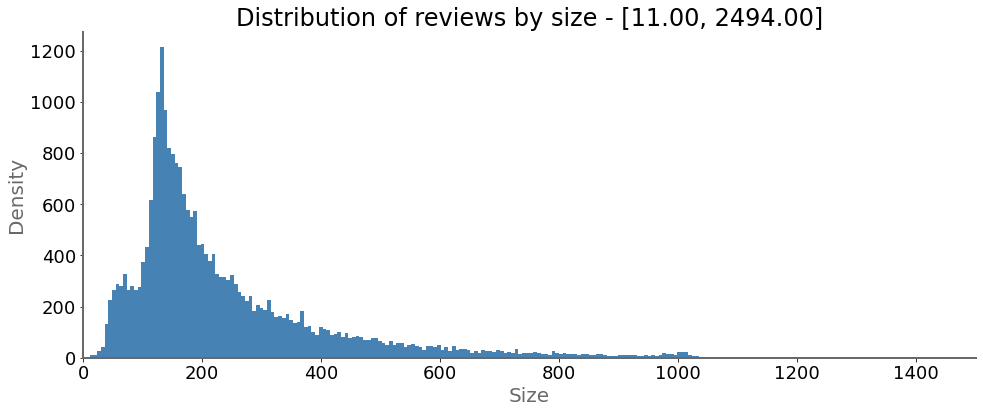

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it
GPU : batch_size=512 :  6' 30s  
CPU : batch_size=512 : 12' 57s

In [12]:
%%time

n_epochs   = 10
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/10


 1/49 [..............................] - ETA: 4:24 - loss: 0.6934 - accuracy: 0.4844

 2/49 [>.............................] - ETA: 28s - loss: 0.6933 - accuracy: 0.4873 

 3/49 [>.............................] - ETA: 28s - loss: 0.6934 - accuracy: 0.4874

 4/49 [=>............................] - ETA: 27s - loss: 0.6934 - accuracy: 0.4897

 5/49 [==>...........................] - ETA: 26s - loss: 0.6933 - accuracy: 0.4920

 6/49 [==>...........................] - ETA: 26s - loss: 0.6934 - accuracy: 0.4928

 7/49 [===>..........................] - ETA: 25s - loss: 0.6934 - accuracy: 0.4934

 8/49 [===>..........................] - ETA: 24s - loss: 0.6934 - accuracy: 0.4937

 9/49 [====>.........................] - ETA: 24s - loss: 0.6934 - accuracy: 0.4941

10/49 [=====>........................] - ETA: 23s - loss: 0.6933 - accuracy: 0.4946

11/49 [=====>........................] - ETA: 23s - loss: 0.6933 - accuracy: 0.4952

12/49 [======>.......................] - ETA: 22s - loss: 0.6933 - accuracy: 0.4957

13/49 [======>.......................] - ETA: 21s - loss: 0.6933 - accuracy: 0.4962

14/49 [=======>......................] - ETA: 21s - loss: 0.6933 - accuracy: 0.4968

15/49 [========>.....................] - ETA: 20s - loss: 0.6933 - accuracy: 0.4972

16/49 [========>.....................] - ETA: 20s - loss: 0.6933 - accuracy: 0.4978

17/49 [=========>....................] - ETA: 19s - loss: 0.6933 - accuracy: 0.4984

18/49 [==========>...................] - ETA: 18s - loss: 0.6933 - accuracy: 0.4990

19/49 [==========>...................] - ETA: 18s - loss: 0.6933 - accuracy: 0.4995

20/49 [===========>..................] - ETA: 17s - loss: 0.6933 - accuracy: 0.5000

21/49 [===========>..................] - ETA: 17s - loss: 0.6932 - accuracy: 0.5004

22/49 [============>.................] - ETA: 16s - loss: 0.6932 - accuracy: 0.5008

23/49 [=============>................] - ETA: 15s - loss: 0.6932 - accuracy: 0.5013

24/49 [=============>................] - ETA: 15s - loss: 0.6932 - accuracy: 0.5017

25/49 [==============>...............] - ETA: 14s - loss: 0.6932 - accuracy: 0.5021

26/49 [==============>...............] - ETA: 14s - loss: 0.6932 - accuracy: 0.5024

27/49 [===============>..............] - ETA: 13s - loss: 0.6932 - accuracy: 0.5028

28/49 [================>.............] - ETA: 12s - loss: 0.6932 - accuracy: 0.5032

29/49 [================>.............] - ETA: 12s - loss: 0.6932 - accuracy: 0.5035

30/49 [=================>............] - ETA: 11s - loss: 0.6932 - accuracy: 0.5039

31/49 [=================>............] - ETA: 11s - loss: 0.6932 - accuracy: 0.5042

32/49 [==================>...........] - ETA: 10s - loss: 0.6932 - accuracy: 0.5045

33/49 [===================>..........] - ETA: 9s - loss: 0.6932 - accuracy: 0.5048 

34/49 [===================>..........] - ETA: 9s - loss: 0.6932 - accuracy: 0.5050

35/49 [====================>.........] - ETA: 8s - loss: 0.6932 - accuracy: 0.5053

36/49 [=====================>........] - ETA: 8s - loss: 0.6931 - accuracy: 0.5055

37/49 [=====================>........] - ETA: 7s - loss: 0.6931 - accuracy: 0.5057

38/49 [======================>.......] - ETA: 6s - loss: 0.6931 - accuracy: 0.5059

39/49 [======================>.......] - ETA: 6s - loss: 0.6931 - accuracy: 0.5061

40/49 [=======================>......] - ETA: 5s - loss: 0.6931 - accuracy: 0.5063

41/49 [========================>.....] - ETA: 5s - loss: 0.6931 - accuracy: 0.5065

42/49 [========================>.....] - ETA: 4s - loss: 0.6931 - accuracy: 0.5067

43/49 [=========================>....] - ETA: 3s - loss: 0.6931 - accuracy: 0.5069

44/49 [=========================>....] - ETA: 3s - loss: 0.6931 - accuracy: 0.5070

45/49 [==========================>...] - ETA: 2s - loss: 0.6930 - accuracy: 0.5072

46/49 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5073

47/49 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5075

48/49 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5077

49/49 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5079

49/49 [==============================] - 40s 729ms/step - loss: 0.6929 - accuracy: 0.5081 - val_loss: 0.6872 - val_accuracy: 0.5398


Epoch 2/10


 1/49 [..............................] - ETA: 29s - loss: 0.6867 - accuracy: 0.5469

 2/49 [>.............................] - ETA: 28s - loss: 0.6864 - accuracy: 0.5532

 3/49 [>.............................] - ETA: 27s - loss: 0.6866 - accuracy: 0.5513

 4/49 [=>............................] - ETA: 27s - loss: 0.6868 - accuracy: 0.5501

 5/49 [==>...........................] - ETA: 27s - loss: 0.6868 - accuracy: 0.5512

 6/49 [==>...........................] - ETA: 28s - loss: 0.6868 - accuracy: 0.5516

 7/49 [===>..........................] - ETA: 28s - loss: 0.6869 - accuracy: 0.5516

 8/49 [===>..........................] - ETA: 28s - loss: 0.6870 - accuracy: 0.5516

 9/49 [====>.........................] - ETA: 28s - loss: 0.6871 - accuracy: 0.5513

10/49 [=====>........................] - ETA: 28s - loss: 0.6872 - accuracy: 0.5512

11/49 [=====>........................] - ETA: 28s - loss: 0.6873 - accuracy: 0.5512

12/49 [======>.......................] - ETA: 27s - loss: 0.6874 - accuracy: 0.5514

13/49 [======>.......................] - ETA: 25s - loss: 0.6874 - accuracy: 0.5518

14/49 [=======>......................] - ETA: 24s - loss: 0.6875 - accuracy: 0.5520

15/49 [========>.....................] - ETA: 23s - loss: 0.6875 - accuracy: 0.5522

16/49 [========>.....................] - ETA: 23s - loss: 0.6876 - accuracy: 0.5526

17/49 [=========>....................] - ETA: 22s - loss: 0.6876 - accuracy: 0.5530

18/49 [==========>...................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5535

19/49 [==========>...................] - ETA: 20s - loss: 0.6876 - accuracy: 0.5538

20/49 [===========>..................] - ETA: 19s - loss: 0.6876 - accuracy: 0.5541

21/49 [===========>..................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5543

22/49 [============>.................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5545

23/49 [=============>................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5547

24/49 [=============>................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5550

25/49 [==============>...............] - ETA: 15s - loss: 0.6876 - accuracy: 0.5552

26/49 [==============>...............] - ETA: 15s - loss: 0.6876 - accuracy: 0.5555

27/49 [===============>..............] - ETA: 14s - loss: 0.6876 - accuracy: 0.5558

28/49 [================>.............] - ETA: 13s - loss: 0.6876 - accuracy: 0.5560

29/49 [================>.............] - ETA: 13s - loss: 0.6876 - accuracy: 0.5563

30/49 [=================>............] - ETA: 12s - loss: 0.6875 - accuracy: 0.5565

31/49 [=================>............] - ETA: 11s - loss: 0.6875 - accuracy: 0.5567

32/49 [==================>...........] - ETA: 11s - loss: 0.6875 - accuracy: 0.5570

33/49 [===================>..........] - ETA: 10s - loss: 0.6875 - accuracy: 0.5572

34/49 [===================>..........] - ETA: 9s - loss: 0.6874 - accuracy: 0.5573 

35/49 [====================>.........] - ETA: 9s - loss: 0.6874 - accuracy: 0.5575

36/49 [=====================>........] - ETA: 8s - loss: 0.6873 - accuracy: 0.5577

37/49 [=====================>........] - ETA: 7s - loss: 0.6873 - accuracy: 0.5578

38/49 [======================>.......] - ETA: 7s - loss: 0.6873 - accuracy: 0.5580

39/49 [======================>.......] - ETA: 6s - loss: 0.6872 - accuracy: 0.5582

40/49 [=======================>......] - ETA: 5s - loss: 0.6872 - accuracy: 0.5583

41/49 [========================>.....] - ETA: 5s - loss: 0.6871 - accuracy: 0.5584

42/49 [========================>.....] - ETA: 4s - loss: 0.6870 - accuracy: 0.5586

43/49 [=========================>....] - ETA: 3s - loss: 0.6870 - accuracy: 0.5588

44/49 [=========================>....] - ETA: 3s - loss: 0.6869 - accuracy: 0.5589

45/49 [==========================>...] - ETA: 2s - loss: 0.6869 - accuracy: 0.5591

46/49 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5592

47/49 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5593

48/49 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5594

49/49 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5595

49/49 [==============================] - 35s 711ms/step - loss: 0.6866 - accuracy: 0.5596 - val_loss: 0.6878 - val_accuracy: 0.5218


Epoch 3/10


 1/49 [..............................] - ETA: 29s - loss: 0.6897 - accuracy: 0.5039

 2/49 [>.............................] - ETA: 28s - loss: 0.6890 - accuracy: 0.5063

 3/49 [>.............................] - ETA: 27s - loss: 0.6882 - accuracy: 0.5088

 4/49 [=>............................] - ETA: 30s - loss: 0.6874 - accuracy: 0.5116

 5/49 [==>...........................] - ETA: 30s - loss: 0.6866 - accuracy: 0.5140

 6/49 [==>...........................] - ETA: 31s - loss: 0.6858 - accuracy: 0.5163

 7/49 [===>..........................] - ETA: 31s - loss: 0.6853 - accuracy: 0.5178

 8/49 [===>..........................] - ETA: 30s - loss: 0.6848 - accuracy: 0.5187

 9/49 [====>.........................] - ETA: 29s - loss: 0.6845 - accuracy: 0.5192

10/49 [=====>........................] - ETA: 29s - loss: 0.6842 - accuracy: 0.5197

11/49 [=====>........................] - ETA: 28s - loss: 0.6839 - accuracy: 0.5203

12/49 [======>.......................] - ETA: 27s - loss: 0.6836 - accuracy: 0.5209

13/49 [======>.......................] - ETA: 25s - loss: 0.6833 - accuracy: 0.5213

14/49 [=======>......................] - ETA: 25s - loss: 0.6830 - accuracy: 0.5218

15/49 [========>.....................] - ETA: 24s - loss: 0.6828 - accuracy: 0.5223

16/49 [========>.....................] - ETA: 24s - loss: 0.6825 - accuracy: 0.5228

17/49 [=========>....................] - ETA: 23s - loss: 0.6823 - accuracy: 0.5232

18/49 [==========>...................] - ETA: 22s - loss: 0.6822 - accuracy: 0.5236

19/49 [==========>...................] - ETA: 21s - loss: 0.6820 - accuracy: 0.5240

20/49 [===========>..................] - ETA: 20s - loss: 0.6818 - accuracy: 0.5245

21/49 [===========>..................] - ETA: 19s - loss: 0.6817 - accuracy: 0.5249

22/49 [============>.................] - ETA: 19s - loss: 0.6815 - accuracy: 0.5253

23/49 [=============>................] - ETA: 18s - loss: 0.6814 - accuracy: 0.5256

24/49 [=============>................] - ETA: 17s - loss: 0.6813 - accuracy: 0.5259

25/49 [==============>...............] - ETA: 16s - loss: 0.6811 - accuracy: 0.5262

26/49 [==============>...............] - ETA: 15s - loss: 0.6810 - accuracy: 0.5264

27/49 [===============>..............] - ETA: 15s - loss: 0.6809 - accuracy: 0.5267

28/49 [================>.............] - ETA: 14s - loss: 0.6808 - accuracy: 0.5270

29/49 [================>.............] - ETA: 13s - loss: 0.6806 - accuracy: 0.5272

30/49 [=================>............] - ETA: 12s - loss: 0.6805 - accuracy: 0.5275

31/49 [=================>............] - ETA: 12s - loss: 0.6804 - accuracy: 0.5277

32/49 [==================>...........] - ETA: 11s - loss: 0.6803 - accuracy: 0.5280

33/49 [===================>..........] - ETA: 10s - loss: 0.6802 - accuracy: 0.5283

34/49 [===================>..........] - ETA: 10s - loss: 0.6800 - accuracy: 0.5287

35/49 [====================>.........] - ETA: 9s - loss: 0.6799 - accuracy: 0.5290 

36/49 [=====================>........] - ETA: 8s - loss: 0.6798 - accuracy: 0.5293

37/49 [=====================>........] - ETA: 8s - loss: 0.6797 - accuracy: 0.5296

38/49 [======================>.......] - ETA: 7s - loss: 0.6796 - accuracy: 0.5299

39/49 [======================>.......] - ETA: 6s - loss: 0.6795 - accuracy: 0.5302

40/49 [=======================>......] - ETA: 6s - loss: 0.6794 - accuracy: 0.5305

41/49 [========================>.....] - ETA: 5s - loss: 0.6792 - accuracy: 0.5308

42/49 [========================>.....] - ETA: 4s - loss: 0.6791 - accuracy: 0.5311

43/49 [=========================>....] - ETA: 4s - loss: 0.6790 - accuracy: 0.5314

44/49 [=========================>....] - ETA: 3s - loss: 0.6789 - accuracy: 0.5317

45/49 [==========================>...] - ETA: 2s - loss: 0.6788 - accuracy: 0.5320

46/49 [===========================>..] - ETA: 2s - loss: 0.6786 - accuracy: 0.5324

47/49 [===========================>..] - ETA: 1s - loss: 0.6785 - accuracy: 0.5327

48/49 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5330

49/49 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.5334

49/49 [==============================] - 36s 734ms/step - loss: 0.6781 - accuracy: 0.5337 - val_loss: 0.6542 - val_accuracy: 0.5936


Epoch 4/10


 1/49 [..............................] - ETA: 29s - loss: 0.6212 - accuracy: 0.6172

 2/49 [>.............................] - ETA: 28s - loss: 0.6292 - accuracy: 0.6323

 3/49 [>.............................] - ETA: 28s - loss: 0.6311 - accuracy: 0.6338

 4/49 [=>............................] - ETA: 27s - loss: 0.6318 - accuracy: 0.6333

 5/49 [==>...........................] - ETA: 27s - loss: 0.6324 - accuracy: 0.6318

 6/49 [==>...........................] - ETA: 26s - loss: 0.6327 - accuracy: 0.6309

 7/49 [===>..........................] - ETA: 26s - loss: 0.6329 - accuracy: 0.6306

 8/49 [===>..........................] - ETA: 25s - loss: 0.6331 - accuracy: 0.6300

 9/49 [====>.........................] - ETA: 24s - loss: 0.6334 - accuracy: 0.6293

10/49 [=====>........................] - ETA: 23s - loss: 0.6336 - accuracy: 0.6284

11/49 [=====>........................] - ETA: 23s - loss: 0.6335 - accuracy: 0.6280

12/49 [======>.......................] - ETA: 23s - loss: 0.6334 - accuracy: 0.6282

13/49 [======>.......................] - ETA: 22s - loss: 0.6329 - accuracy: 0.6288

14/49 [=======>......................] - ETA: 22s - loss: 0.6331 - accuracy: 0.6294

15/49 [========>.....................] - ETA: 21s - loss: 0.6329 - accuracy: 0.6302

16/49 [========>.....................] - ETA: 21s - loss: 0.6327 - accuracy: 0.6310

17/49 [=========>....................] - ETA: 21s - loss: 0.6326 - accuracy: 0.6315

18/49 [==========>...................] - ETA: 20s - loss: 0.6326 - accuracy: 0.6318

19/49 [==========>...................] - ETA: 19s - loss: 0.6326 - accuracy: 0.6321

20/49 [===========>..................] - ETA: 19s - loss: 0.6326 - accuracy: 0.6322

21/49 [===========>..................] - ETA: 18s - loss: 0.6327 - accuracy: 0.6321

22/49 [============>.................] - ETA: 17s - loss: 0.6328 - accuracy: 0.6320

23/49 [=============>................] - ETA: 16s - loss: 0.6328 - accuracy: 0.6319

24/49 [=============>................] - ETA: 16s - loss: 0.6329 - accuracy: 0.6318

25/49 [==============>...............] - ETA: 15s - loss: 0.6329 - accuracy: 0.6317

26/49 [==============>...............] - ETA: 14s - loss: 0.6329 - accuracy: 0.6316

27/49 [===============>..............] - ETA: 14s - loss: 0.6329 - accuracy: 0.6314

28/49 [================>.............] - ETA: 13s - loss: 0.6328 - accuracy: 0.6313

29/49 [================>.............] - ETA: 13s - loss: 0.6328 - accuracy: 0.6311

30/49 [=================>............] - ETA: 12s - loss: 0.6328 - accuracy: 0.6310

31/49 [=================>............] - ETA: 12s - loss: 0.6327 - accuracy: 0.6309

32/49 [==================>...........] - ETA: 11s - loss: 0.6327 - accuracy: 0.6306

33/49 [===================>..........] - ETA: 10s - loss: 0.6326 - accuracy: 0.6305

34/49 [===================>..........] - ETA: 9s - loss: 0.6326 - accuracy: 0.6303 

35/49 [====================>.........] - ETA: 9s - loss: 0.6325 - accuracy: 0.6302

36/49 [=====================>........] - ETA: 8s - loss: 0.6323 - accuracy: 0.6301

37/49 [=====================>........] - ETA: 7s - loss: 0.6321 - accuracy: 0.6301

38/49 [======================>.......] - ETA: 7s - loss: 0.6319 - accuracy: 0.6302

39/49 [======================>.......] - ETA: 6s - loss: 0.6315 - accuracy: 0.6304

40/49 [=======================>......] - ETA: 5s - loss: 0.6311 - accuracy: 0.6307

41/49 [========================>.....] - ETA: 5s - loss: 0.6306 - accuracy: 0.6310

42/49 [========================>.....] - ETA: 4s - loss: 0.6301 - accuracy: 0.6314

43/49 [=========================>....] - ETA: 3s - loss: 0.6296 - accuracy: 0.6319

44/49 [=========================>....] - ETA: 3s - loss: 0.6290 - accuracy: 0.6324

45/49 [==========================>...] - ETA: 2s - loss: 0.6284 - accuracy: 0.6329

46/49 [===========================>..] - ETA: 1s - loss: 0.6278 - accuracy: 0.6335

47/49 [===========================>..] - ETA: 1s - loss: 0.6271 - accuracy: 0.6342

48/49 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6349

49/49 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.6356

49/49 [==============================] - 35s 717ms/step - loss: 0.6251 - accuracy: 0.6363 - val_loss: 0.4778 - val_accuracy: 0.8142


Epoch 5/10


 1/49 [..............................] - ETA: 30s - loss: 0.4150 - accuracy: 0.8555

 2/49 [>.............................] - ETA: 29s - loss: 0.4185 - accuracy: 0.8511

 3/49 [>.............................] - ETA: 33s - loss: 0.4198 - accuracy: 0.8478

 4/49 [=>............................] - ETA: 31s - loss: 0.4204 - accuracy: 0.8457

 5/49 [==>...........................] - ETA: 29s - loss: 0.4218 - accuracy: 0.8431

 6/49 [==>...........................] - ETA: 28s - loss: 0.4221 - accuracy: 0.8415

 7/49 [===>..........................] - ETA: 27s - loss: 0.4223 - accuracy: 0.8403

 8/49 [===>..........................] - ETA: 26s - loss: 0.4217 - accuracy: 0.8400

 9/49 [====>.........................] - ETA: 25s - loss: 0.4235 - accuracy: 0.8378

10/49 [=====>........................] - ETA: 24s - loss: 0.4269 - accuracy: 0.8343

11/49 [=====>........................] - ETA: 24s - loss: 0.4314 - accuracy: 0.8296

12/49 [======>.......................] - ETA: 23s - loss: 0.4365 - accuracy: 0.8243

13/49 [======>.......................] - ETA: 22s - loss: 0.4417 - accuracy: 0.8187

14/49 [=======>......................] - ETA: 21s - loss: 0.4468 - accuracy: 0.8132

15/49 [========>.....................] - ETA: 21s - loss: 0.4518 - accuracy: 0.8077

16/49 [========>.....................] - ETA: 20s - loss: 0.4567 - accuracy: 0.8025

17/49 [=========>....................] - ETA: 20s - loss: 0.4614 - accuracy: 0.7975

18/49 [==========>...................] - ETA: 19s - loss: 0.4659 - accuracy: 0.7927

19/49 [==========>...................] - ETA: 19s - loss: 0.4702 - accuracy: 0.7880

20/49 [===========>..................] - ETA: 19s - loss: 0.4743 - accuracy: 0.7835

21/49 [===========>..................] - ETA: 18s - loss: 0.4782 - accuracy: 0.7791

22/49 [============>.................] - ETA: 18s - loss: 0.4820 - accuracy: 0.7750

23/49 [=============>................] - ETA: 17s - loss: 0.4856 - accuracy: 0.7709

24/49 [=============>................] - ETA: 17s - loss: 0.4891 - accuracy: 0.7671

25/49 [==============>...............] - ETA: 16s - loss: 0.4923 - accuracy: 0.7634

26/49 [==============>...............] - ETA: 15s - loss: 0.4954 - accuracy: 0.7599

27/49 [===============>..............] - ETA: 14s - loss: 0.4984 - accuracy: 0.7566

28/49 [================>.............] - ETA: 14s - loss: 0.5013 - accuracy: 0.7533

29/49 [================>.............] - ETA: 13s - loss: 0.5040 - accuracy: 0.7503

30/49 [=================>............] - ETA: 12s - loss: 0.5067 - accuracy: 0.7473

31/49 [=================>............] - ETA: 12s - loss: 0.5092 - accuracy: 0.7444

32/49 [==================>...........] - ETA: 11s - loss: 0.5116 - accuracy: 0.7417

33/49 [===================>..........] - ETA: 10s - loss: 0.5140 - accuracy: 0.7390

34/49 [===================>..........] - ETA: 9s - loss: 0.5162 - accuracy: 0.7365 

35/49 [====================>.........] - ETA: 9s - loss: 0.5184 - accuracy: 0.7340

36/49 [=====================>........] - ETA: 8s - loss: 0.5205 - accuracy: 0.7317

37/49 [=====================>........] - ETA: 7s - loss: 0.5225 - accuracy: 0.7294

38/49 [======================>.......] - ETA: 7s - loss: 0.5244 - accuracy: 0.7272

39/49 [======================>.......] - ETA: 6s - loss: 0.5263 - accuracy: 0.7250

40/49 [=======================>......] - ETA: 5s - loss: 0.5281 - accuracy: 0.7230

41/49 [========================>.....] - ETA: 5s - loss: 0.5298 - accuracy: 0.7210

42/49 [========================>.....] - ETA: 4s - loss: 0.5315 - accuracy: 0.7191

43/49 [=========================>....] - ETA: 3s - loss: 0.5331 - accuracy: 0.7172

44/49 [=========================>....] - ETA: 3s - loss: 0.5347 - accuracy: 0.7154

45/49 [==========================>...] - ETA: 2s - loss: 0.5362 - accuracy: 0.7137

46/49 [===========================>..] - ETA: 1s - loss: 0.5377 - accuracy: 0.7120

47/49 [===========================>..] - ETA: 1s - loss: 0.5391 - accuracy: 0.7103

48/49 [============================>.] - ETA: 0s - loss: 0.5405 - accuracy: 0.7087

49/49 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7072

49/49 [==============================] - 35s 719ms/step - loss: 0.5431 - accuracy: 0.7057 - val_loss: 0.6568 - val_accuracy: 0.5691


Epoch 6/10


 1/49 [..............................] - ETA: 29s - loss: 0.6380 - accuracy: 0.6211

 2/49 [>.............................] - ETA: 28s - loss: 0.6353 - accuracy: 0.6240

 3/49 [>.............................] - ETA: 27s - loss: 0.6348 - accuracy: 0.6224

 4/49 [=>............................] - ETA: 30s - loss: 0.6346 - accuracy: 0.6193

 5/49 [==>...........................] - ETA: 28s - loss: 0.6348 - accuracy: 0.6147

 6/49 [==>...........................] - ETA: 27s - loss: 0.6345 - accuracy: 0.6120

 7/49 [===>..........................] - ETA: 27s - loss: 0.6342 - accuracy: 0.6098

 8/49 [===>..........................] - ETA: 26s - loss: 0.6338 - accuracy: 0.6081

 9/49 [====>.........................] - ETA: 25s - loss: 0.6335 - accuracy: 0.6063

10/49 [=====>........................] - ETA: 24s - loss: 0.6333 - accuracy: 0.6050

11/49 [=====>........................] - ETA: 24s - loss: 0.6331 - accuracy: 0.6041

12/49 [======>.......................] - ETA: 23s - loss: 0.6329 - accuracy: 0.6033

13/49 [======>.......................] - ETA: 22s - loss: 0.6328 - accuracy: 0.6026

14/49 [=======>......................] - ETA: 22s - loss: 0.6327 - accuracy: 0.6021

15/49 [========>.....................] - ETA: 21s - loss: 0.6326 - accuracy: 0.6017

16/49 [========>.....................] - ETA: 20s - loss: 0.6324 - accuracy: 0.6015

17/49 [=========>....................] - ETA: 20s - loss: 0.6323 - accuracy: 0.6013

18/49 [==========>...................] - ETA: 19s - loss: 0.6321 - accuracy: 0.6012

19/49 [==========>...................] - ETA: 18s - loss: 0.6320 - accuracy: 0.6011

20/49 [===========>..................] - ETA: 18s - loss: 0.6317 - accuracy: 0.6012

21/49 [===========>..................] - ETA: 17s - loss: 0.6315 - accuracy: 0.6013

22/49 [============>.................] - ETA: 16s - loss: 0.6313 - accuracy: 0.6015

23/49 [=============>................] - ETA: 16s - loss: 0.6310 - accuracy: 0.6019

24/49 [=============>................] - ETA: 15s - loss: 0.6307 - accuracy: 0.6022

25/49 [==============>...............] - ETA: 14s - loss: 0.6304 - accuracy: 0.6026

26/49 [==============>...............] - ETA: 14s - loss: 0.6300 - accuracy: 0.6032

27/49 [===============>..............] - ETA: 13s - loss: 0.6295 - accuracy: 0.6040

28/49 [================>.............] - ETA: 13s - loss: 0.6288 - accuracy: 0.6049

29/49 [================>.............] - ETA: 12s - loss: 0.6278 - accuracy: 0.6061

30/49 [=================>............] - ETA: 11s - loss: 0.6269 - accuracy: 0.6074

31/49 [=================>............] - ETA: 11s - loss: 0.6259 - accuracy: 0.6087

32/49 [==================>...........] - ETA: 10s - loss: 0.6249 - accuracy: 0.6101

33/49 [===================>..........] - ETA: 9s - loss: 0.6237 - accuracy: 0.6116 

34/49 [===================>..........] - ETA: 9s - loss: 0.6226 - accuracy: 0.6132

35/49 [====================>.........] - ETA: 8s - loss: 0.6213 - accuracy: 0.6148

36/49 [=====================>........] - ETA: 8s - loss: 0.6200 - accuracy: 0.6165

37/49 [=====================>........] - ETA: 7s - loss: 0.6187 - accuracy: 0.6182

38/49 [======================>.......] - ETA: 6s - loss: 0.6174 - accuracy: 0.6199

39/49 [======================>.......] - ETA: 6s - loss: 0.6161 - accuracy: 0.6217

40/49 [=======================>......] - ETA: 5s - loss: 0.6148 - accuracy: 0.6234

41/49 [========================>.....] - ETA: 4s - loss: 0.6135 - accuracy: 0.6252

42/49 [========================>.....] - ETA: 4s - loss: 0.6122 - accuracy: 0.6270

43/49 [=========================>....] - ETA: 3s - loss: 0.6109 - accuracy: 0.6287

44/49 [=========================>....] - ETA: 3s - loss: 0.6096 - accuracy: 0.6305

45/49 [==========================>...] - ETA: 2s - loss: 0.6082 - accuracy: 0.6323

46/49 [===========================>..] - ETA: 1s - loss: 0.6069 - accuracy: 0.6340

47/49 [===========================>..] - ETA: 1s - loss: 0.6055 - accuracy: 0.6357

48/49 [============================>.] - ETA: 0s - loss: 0.6042 - accuracy: 0.6374

49/49 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6390

49/49 [==============================] - 34s 686ms/step - loss: 0.6016 - accuracy: 0.6406 - val_loss: 0.4373 - val_accuracy: 0.8191


Epoch 7/10


 1/49 [..............................] - ETA: 32s - loss: 0.3965 - accuracy: 0.8418

 2/49 [>.............................] - ETA: 41s - loss: 0.3964 - accuracy: 0.8403

 3/49 [>.............................] - ETA: 36s - loss: 0.3960 - accuracy: 0.8421

 4/49 [=>............................] - ETA: 36s - loss: 0.3951 - accuracy: 0.8440

 5/49 [==>...........................] - ETA: 35s - loss: 0.3945 - accuracy: 0.8456

 6/49 [==>...........................] - ETA: 34s - loss: 0.3939 - accuracy: 0.8467

 7/49 [===>..........................] - ETA: 32s - loss: 0.3938 - accuracy: 0.8473

 8/49 [===>..........................] - ETA: 31s - loss: 0.3937 - accuracy: 0.8480

 9/49 [====>.........................] - ETA: 29s - loss: 0.3948 - accuracy: 0.8485

10/49 [=====>........................] - ETA: 28s - loss: 0.3975 - accuracy: 0.8486

11/49 [=====>........................] - ETA: 27s - loss: 0.4014 - accuracy: 0.8484

12/49 [======>.......................] - ETA: 26s - loss: 0.4057 - accuracy: 0.8478

13/49 [======>.......................] - ETA: 25s - loss: 0.4093 - accuracy: 0.8473

14/49 [=======>......................] - ETA: 24s - loss: 0.4121 - accuracy: 0.8469

15/49 [========>.....................] - ETA: 23s - loss: 0.4144 - accuracy: 0.8466

16/49 [========>.....................] - ETA: 22s - loss: 0.4161 - accuracy: 0.8465

17/49 [=========>....................] - ETA: 22s - loss: 0.4175 - accuracy: 0.8463

18/49 [==========>...................] - ETA: 21s - loss: 0.4185 - accuracy: 0.8462

19/49 [==========>...................] - ETA: 21s - loss: 0.4194 - accuracy: 0.8461

20/49 [===========>..................] - ETA: 20s - loss: 0.4203 - accuracy: 0.8459

21/49 [===========>..................] - ETA: 20s - loss: 0.4210 - accuracy: 0.8458

22/49 [============>.................] - ETA: 19s - loss: 0.4215 - accuracy: 0.8457

23/49 [=============>................] - ETA: 18s - loss: 0.4219 - accuracy: 0.8457

24/49 [=============>................] - ETA: 18s - loss: 0.4223 - accuracy: 0.8457

25/49 [==============>...............] - ETA: 17s - loss: 0.4225 - accuracy: 0.8457

26/49 [==============>...............] - ETA: 16s - loss: 0.4227 - accuracy: 0.8458

27/49 [===============>..............] - ETA: 15s - loss: 0.4229 - accuracy: 0.8458

28/49 [================>.............] - ETA: 14s - loss: 0.4229 - accuracy: 0.8459

29/49 [================>.............] - ETA: 14s - loss: 0.4229 - accuracy: 0.8459

30/49 [=================>............] - ETA: 13s - loss: 0.4229 - accuracy: 0.8460

31/49 [=================>............] - ETA: 12s - loss: 0.4229 - accuracy: 0.8461

32/49 [==================>...........] - ETA: 11s - loss: 0.4228 - accuracy: 0.8462

33/49 [===================>..........] - ETA: 11s - loss: 0.4227 - accuracy: 0.8463

34/49 [===================>..........] - ETA: 10s - loss: 0.4225 - accuracy: 0.8464

35/49 [====================>.........] - ETA: 9s - loss: 0.4224 - accuracy: 0.8465 

36/49 [=====================>........] - ETA: 9s - loss: 0.4222 - accuracy: 0.8466

37/49 [=====================>........] - ETA: 8s - loss: 0.4220 - accuracy: 0.8467

38/49 [======================>.......] - ETA: 7s - loss: 0.4219 - accuracy: 0.8468

39/49 [======================>.......] - ETA: 6s - loss: 0.4217 - accuracy: 0.8468

40/49 [=======================>......] - ETA: 6s - loss: 0.4215 - accuracy: 0.8469

41/49 [========================>.....] - ETA: 5s - loss: 0.4213 - accuracy: 0.8470

42/49 [========================>.....] - ETA: 4s - loss: 0.4211 - accuracy: 0.8471

43/49 [=========================>....] - ETA: 4s - loss: 0.4209 - accuracy: 0.8472

44/49 [=========================>....] - ETA: 3s - loss: 0.4207 - accuracy: 0.8472

45/49 [==========================>...] - ETA: 2s - loss: 0.4205 - accuracy: 0.8473

46/49 [===========================>..] - ETA: 2s - loss: 0.4203 - accuracy: 0.8474

47/49 [===========================>..] - ETA: 1s - loss: 0.4200 - accuracy: 0.8475

48/49 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8476

49/49 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8477

49/49 [==============================] - 37s 758ms/step - loss: 0.4193 - accuracy: 0.8478 - val_loss: 0.4393 - val_accuracy: 0.8380


Epoch 8/10


 1/49 [..............................] - ETA: 31s - loss: 0.3990 - accuracy: 0.8555

 2/49 [>.............................] - ETA: 29s - loss: 0.4026 - accuracy: 0.8545

 3/49 [>.............................] - ETA: 28s - loss: 0.4029 - accuracy: 0.8548

 4/49 [=>............................] - ETA: 27s - loss: 0.4001 - accuracy: 0.8564

 5/49 [==>...........................] - ETA: 27s - loss: 0.3960 - accuracy: 0.8585

 6/49 [==>...........................] - ETA: 26s - loss: 0.3956 - accuracy: 0.8583

 7/49 [===>..........................] - ETA: 27s - loss: 0.3955 - accuracy: 0.8584

 8/49 [===>..........................] - ETA: 26s - loss: 0.3955 - accuracy: 0.8586

 9/49 [====>.........................] - ETA: 26s - loss: 0.3955 - accuracy: 0.8589

10/49 [=====>........................] - ETA: 26s - loss: 0.3956 - accuracy: 0.8592

11/49 [=====>........................] - ETA: 25s - loss: 0.3956 - accuracy: 0.8595

12/49 [======>.......................] - ETA: 24s - loss: 0.3958 - accuracy: 0.8595

13/49 [======>.......................] - ETA: 23s - loss: 0.3962 - accuracy: 0.8594

14/49 [=======>......................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8592

15/49 [========>.....................] - ETA: 22s - loss: 0.3969 - accuracy: 0.8591

16/49 [========>.....................] - ETA: 21s - loss: 0.3969 - accuracy: 0.8591

17/49 [=========>....................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8590

18/49 [==========>...................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8590

19/49 [==========>...................] - ETA: 19s - loss: 0.3969 - accuracy: 0.8590

20/49 [===========>..................] - ETA: 18s - loss: 0.3979 - accuracy: 0.8585

21/49 [===========>..................] - ETA: 17s - loss: 0.3998 - accuracy: 0.8576

22/49 [============>.................] - ETA: 17s - loss: 0.4026 - accuracy: 0.8562

23/49 [=============>................] - ETA: 16s - loss: 0.4061 - accuracy: 0.8544

24/49 [=============>................] - ETA: 15s - loss: 0.4100 - accuracy: 0.8523

25/49 [==============>...............] - ETA: 15s - loss: 0.4142 - accuracy: 0.8500

26/49 [==============>...............] - ETA: 14s - loss: 0.4185 - accuracy: 0.8476

27/49 [===============>..............] - ETA: 14s - loss: 0.4227 - accuracy: 0.8451

28/49 [================>.............] - ETA: 13s - loss: 0.4267 - accuracy: 0.8426

29/49 [================>.............] - ETA: 12s - loss: 0.4305 - accuracy: 0.8402

30/49 [=================>............] - ETA: 12s - loss: 0.4342 - accuracy: 0.8379

31/49 [=================>............] - ETA: 11s - loss: 0.4379 - accuracy: 0.8354

32/49 [==================>...........] - ETA: 10s - loss: 0.4415 - accuracy: 0.8330

33/49 [===================>..........] - ETA: 10s - loss: 0.4451 - accuracy: 0.8305

34/49 [===================>..........] - ETA: 9s - loss: 0.4487 - accuracy: 0.8280 

35/49 [====================>.........] - ETA: 8s - loss: 0.4522 - accuracy: 0.8256

36/49 [=====================>........] - ETA: 8s - loss: 0.4557 - accuracy: 0.8231

37/49 [=====================>........] - ETA: 7s - loss: 0.4591 - accuracy: 0.8207

38/49 [======================>.......] - ETA: 6s - loss: 0.4624 - accuracy: 0.8182

39/49 [======================>.......] - ETA: 6s - loss: 0.4656 - accuracy: 0.8158

40/49 [=======================>......] - ETA: 5s - loss: 0.4687 - accuracy: 0.8135

41/49 [========================>.....] - ETA: 5s - loss: 0.4717 - accuracy: 0.8112

42/49 [========================>.....] - ETA: 4s - loss: 0.4746 - accuracy: 0.8089

43/49 [=========================>....] - ETA: 3s - loss: 0.4773 - accuracy: 0.8067

44/49 [=========================>....] - ETA: 3s - loss: 0.4800 - accuracy: 0.8045

45/49 [==========================>...] - ETA: 2s - loss: 0.4825 - accuracy: 0.8024

46/49 [===========================>..] - ETA: 1s - loss: 0.4850 - accuracy: 0.8002

47/49 [===========================>..] - ETA: 1s - loss: 0.4874 - accuracy: 0.7982

48/49 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.7961

49/49 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7941

49/49 [==============================] - 38s 768ms/step - loss: 0.4941 - accuracy: 0.7922 - val_loss: 0.6647 - val_accuracy: 0.5551


Epoch 9/10


 1/49 [..............................] - ETA: 29s - loss: 0.6260 - accuracy: 0.6113

 2/49 [>.............................] - ETA: 28s - loss: 0.6297 - accuracy: 0.6113

 3/49 [>.............................] - ETA: 30s - loss: 0.6306 - accuracy: 0.6128

 4/49 [=>............................] - ETA: 29s - loss: 0.6316 - accuracy: 0.6123

 5/49 [==>...........................] - ETA: 28s - loss: 0.6326 - accuracy: 0.6110

 6/49 [==>...........................] - ETA: 27s - loss: 0.6336 - accuracy: 0.6081

 7/49 [===>..........................] - ETA: 28s - loss: 0.6343 - accuracy: 0.6060

 8/49 [===>..........................] - ETA: 28s - loss: 0.6349 - accuracy: 0.6045

 9/49 [====>.........................] - ETA: 28s - loss: 0.6355 - accuracy: 0.6029

10/49 [=====>........................] - ETA: 28s - loss: 0.6359 - accuracy: 0.6018

11/49 [=====>........................] - ETA: 27s - loss: 0.6362 - accuracy: 0.6007

12/49 [======>.......................] - ETA: 26s - loss: 0.6365 - accuracy: 0.5998

13/49 [======>.......................] - ETA: 25s - loss: 0.6368 - accuracy: 0.5990

14/49 [=======>......................] - ETA: 24s - loss: 0.6370 - accuracy: 0.5985

15/49 [========>.....................] - ETA: 24s - loss: 0.6371 - accuracy: 0.5982

16/49 [========>.....................] - ETA: 23s - loss: 0.6373 - accuracy: 0.5980

17/49 [=========>....................] - ETA: 22s - loss: 0.6373 - accuracy: 0.5979

18/49 [==========>...................] - ETA: 21s - loss: 0.6374 - accuracy: 0.5977

19/49 [==========>...................] - ETA: 20s - loss: 0.6375 - accuracy: 0.5977

20/49 [===========>..................] - ETA: 19s - loss: 0.6376 - accuracy: 0.5975

21/49 [===========>..................] - ETA: 19s - loss: 0.6377 - accuracy: 0.5974

22/49 [============>.................] - ETA: 18s - loss: 0.6378 - accuracy: 0.5972

23/49 [=============>................] - ETA: 17s - loss: 0.6378 - accuracy: 0.5971

24/49 [=============>................] - ETA: 16s - loss: 0.6379 - accuracy: 0.5969

25/49 [==============>...............] - ETA: 16s - loss: 0.6379 - accuracy: 0.5968

26/49 [==============>...............] - ETA: 15s - loss: 0.6379 - accuracy: 0.5966

27/49 [===============>..............] - ETA: 14s - loss: 0.6380 - accuracy: 0.5966

28/49 [================>.............] - ETA: 14s - loss: 0.6380 - accuracy: 0.5965

29/49 [================>.............] - ETA: 13s - loss: 0.6380 - accuracy: 0.5965

30/49 [=================>............] - ETA: 12s - loss: 0.6380 - accuracy: 0.5965

31/49 [=================>............] - ETA: 11s - loss: 0.6380 - accuracy: 0.5965

32/49 [==================>...........] - ETA: 11s - loss: 0.6380 - accuracy: 0.5965

33/49 [===================>..........] - ETA: 10s - loss: 0.6379 - accuracy: 0.5965

34/49 [===================>..........] - ETA: 9s - loss: 0.6379 - accuracy: 0.5965 

35/49 [====================>.........] - ETA: 9s - loss: 0.6379 - accuracy: 0.5965

36/49 [=====================>........] - ETA: 8s - loss: 0.6378 - accuracy: 0.5966

37/49 [=====================>........] - ETA: 7s - loss: 0.6378 - accuracy: 0.5966

38/49 [======================>.......] - ETA: 7s - loss: 0.6377 - accuracy: 0.5967

39/49 [======================>.......] - ETA: 6s - loss: 0.6377 - accuracy: 0.5968

40/49 [=======================>......] - ETA: 5s - loss: 0.6376 - accuracy: 0.5968

41/49 [========================>.....] - ETA: 5s - loss: 0.6376 - accuracy: 0.5969

42/49 [========================>.....] - ETA: 4s - loss: 0.6375 - accuracy: 0.5970

43/49 [=========================>....] - ETA: 3s - loss: 0.6375 - accuracy: 0.5970

44/49 [=========================>....] - ETA: 3s - loss: 0.6374 - accuracy: 0.5971

45/49 [==========================>...] - ETA: 2s - loss: 0.6373 - accuracy: 0.5972

46/49 [===========================>..] - ETA: 1s - loss: 0.6373 - accuracy: 0.5973

47/49 [===========================>..] - ETA: 1s - loss: 0.6372 - accuracy: 0.5974

48/49 [============================>.] - ETA: 0s - loss: 0.6371 - accuracy: 0.5975

49/49 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.5976

49/49 [==============================] - 35s 721ms/step - loss: 0.6370 - accuracy: 0.5978 - val_loss: 0.6521 - val_accuracy: 0.5800


Epoch 10/10


 1/49 [..............................] - ETA: 31s - loss: 0.6282 - accuracy: 0.6055

 2/49 [>.............................] - ETA: 28s - loss: 0.6287 - accuracy: 0.6147

 3/49 [>.............................] - ETA: 27s - loss: 0.6288 - accuracy: 0.6130

 4/49 [=>............................] - ETA: 27s - loss: 0.6292 - accuracy: 0.6107

 5/49 [==>...........................] - ETA: 26s - loss: 0.6297 - accuracy: 0.6102

 6/49 [==>...........................] - ETA: 26s - loss: 0.6296 - accuracy: 0.6102

 7/49 [===>..........................] - ETA: 25s - loss: 0.6292 - accuracy: 0.6108

 8/49 [===>..........................] - ETA: 25s - loss: 0.6288 - accuracy: 0.6114

 9/49 [====>.........................] - ETA: 24s - loss: 0.6284 - accuracy: 0.6125

10/49 [=====>........................] - ETA: 23s - loss: 0.6279 - accuracy: 0.6134

11/49 [=====>........................] - ETA: 23s - loss: 0.6274 - accuracy: 0.6142

12/49 [======>.......................] - ETA: 22s - loss: 0.6268 - accuracy: 0.6151

13/49 [======>.......................] - ETA: 21s - loss: 0.6262 - accuracy: 0.6158

14/49 [=======>......................] - ETA: 21s - loss: 0.6256 - accuracy: 0.6164

15/49 [========>.....................] - ETA: 20s - loss: 0.6250 - accuracy: 0.6170

16/49 [========>.....................] - ETA: 20s - loss: 0.6245 - accuracy: 0.6174

17/49 [=========>....................] - ETA: 19s - loss: 0.6241 - accuracy: 0.6178

18/49 [==========>...................] - ETA: 18s - loss: 0.6236 - accuracy: 0.6182

19/49 [==========>...................] - ETA: 18s - loss: 0.6231 - accuracy: 0.6186

20/49 [===========>..................] - ETA: 17s - loss: 0.6226 - accuracy: 0.6191

21/49 [===========>..................] - ETA: 17s - loss: 0.6221 - accuracy: 0.6196

22/49 [============>.................] - ETA: 16s - loss: 0.6215 - accuracy: 0.6204

23/49 [=============>................] - ETA: 15s - loss: 0.6208 - accuracy: 0.6213

24/49 [=============>................] - ETA: 15s - loss: 0.6201 - accuracy: 0.6225

25/49 [==============>...............] - ETA: 14s - loss: 0.6193 - accuracy: 0.6238

26/49 [==============>...............] - ETA: 14s - loss: 0.6183 - accuracy: 0.6253

27/49 [===============>..............] - ETA: 13s - loss: 0.6172 - accuracy: 0.6270

28/49 [================>.............] - ETA: 12s - loss: 0.6160 - accuracy: 0.6287

29/49 [================>.............] - ETA: 12s - loss: 0.6146 - accuracy: 0.6305

30/49 [=================>............] - ETA: 11s - loss: 0.6131 - accuracy: 0.6324

31/49 [=================>............] - ETA: 10s - loss: 0.6117 - accuracy: 0.6342

32/49 [==================>...........] - ETA: 10s - loss: 0.6102 - accuracy: 0.6361

33/49 [===================>..........] - ETA: 9s - loss: 0.6087 - accuracy: 0.6381 

34/49 [===================>..........] - ETA: 9s - loss: 0.6071 - accuracy: 0.6401

35/49 [====================>.........] - ETA: 8s - loss: 0.6055 - accuracy: 0.6421

36/49 [=====================>........] - ETA: 7s - loss: 0.6039 - accuracy: 0.6441

37/49 [=====================>........] - ETA: 7s - loss: 0.6023 - accuracy: 0.6462

38/49 [======================>.......] - ETA: 6s - loss: 0.6006 - accuracy: 0.6482

39/49 [======================>.......] - ETA: 6s - loss: 0.5990 - accuracy: 0.6502

40/49 [=======================>......] - ETA: 5s - loss: 0.5974 - accuracy: 0.6522

41/49 [========================>.....] - ETA: 4s - loss: 0.5957 - accuracy: 0.6541

42/49 [========================>.....] - ETA: 4s - loss: 0.5941 - accuracy: 0.6561

43/49 [=========================>....] - ETA: 3s - loss: 0.5925 - accuracy: 0.6580

44/49 [=========================>....] - ETA: 3s - loss: 0.5909 - accuracy: 0.6599

45/49 [==========================>...] - ETA: 2s - loss: 0.5892 - accuracy: 0.6617

46/49 [===========================>..] - ETA: 1s - loss: 0.5876 - accuracy: 0.6636

47/49 [===========================>..] - ETA: 1s - loss: 0.5860 - accuracy: 0.6654

48/49 [============================>.] - ETA: 0s - loss: 0.5844 - accuracy: 0.6672

49/49 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.6690

49/49 [==============================] - 33s 681ms/step - loss: 0.5812 - accuracy: 0.6707 - val_loss: 0.4222 - val_accuracy: 0.8380


CPU times: user 11min 18s, sys: 46.6 s, total: 12min 4s
Wall time: 5min 58s


## Step 6 - Evaluate
### 6.1 - Training history

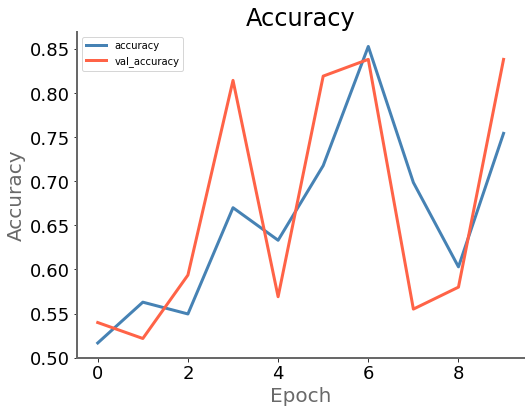

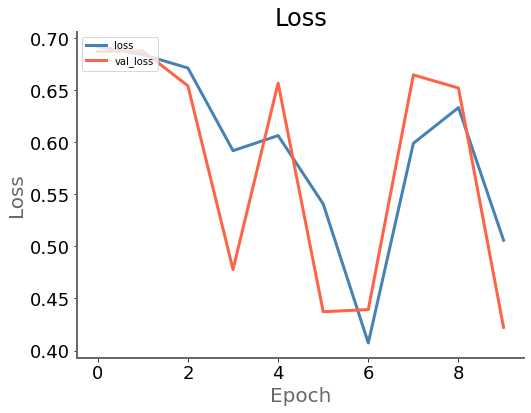

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.4222
x_test / accuracy  : 0.8380


#### Accuracy donut is :

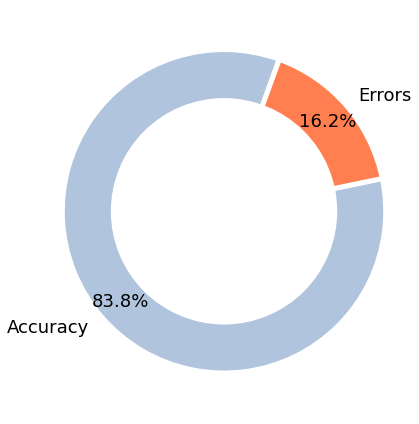

#### Confusion matrix is :

,0,1
0,0.86,0.14
1,0.18,0.82


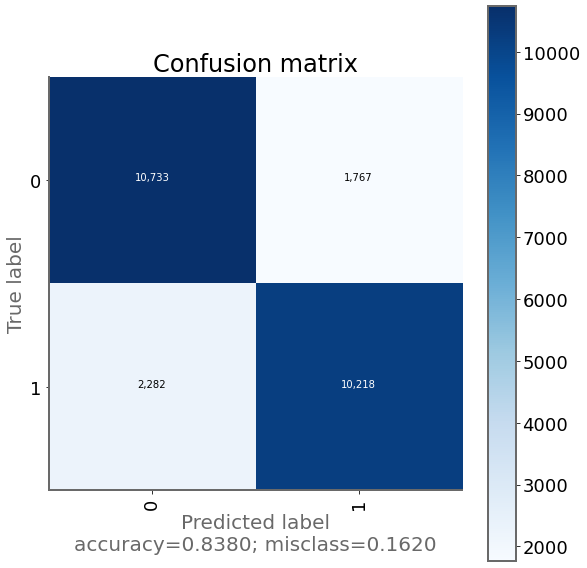

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Tuesday 09 February 2021, 19:53:28
Duration is : 00:07:57 183ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>